# Keras callbacks

In [1]:
%autosave 120
import numpy as np
np.random.seed(1337)
import datetime
import graphviz
from   IPython.display import SVG
from   keras.datasets import mnist
import keras
from   keras import activations
from   keras import backend as K
from   keras.layers import (
           concatenate,
           Concatenate,
           Conv1D,
           Conv2D,
           Dense,
           Dropout,
           Embedding,
           Flatten,
           Input,
           MaxPooling1D,
           MaxPooling2D)
from   keras.models import Model, Sequential, load_model
from   keras_tqdm import TQDMNotebookCallback
from   keras.utils import plot_model
from   keras.utils.vis_utils import model_to_dot
from   matplotlib import gridspec
import matplotlib.pylab as plt
from   matplotlib.ticker import NullFormatter, NullLocator, MultipleLocator
import pandas as pd
import random
from   scipy import stats
import seaborn as sns
from   sklearn.datasets import load_iris
import sklearn.ensemble
import sklearn.tree
from   sklearn.metrics import auc, roc_curve
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler
import sqlite3
import talos as ta
from   tqdm import tqdm_notebook
import uuid
from   vis.utils import utils
from   vis.visualization import visualize_activation
from   vis.visualization import visualize_saliency
import warnings

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows",    500)
sns.set_palette('husl')
sns.set(style='ticks')
warnings.filterwarnings("ignore")

Autosaving every 120 seconds


Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

# callbacks

In [3]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc     = []
        self.val_acc = []
    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
history = AccuracyHistory()

class EpochProgressBar(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.total_epochs  = self.params['epochs']
        self.current_epoch = 0
        self.pbar = tqdm_notebook(total=self.total_epochs, desc='epochs')
    def on_epoch_end(self, batch, logs={}):
        self.current_epoch += 1
        #print(f'epoch {self.current_epoch} of epochs {self.total_epochs}')
        self.pbar.update(1);
epoch_progress_bar = EpochProgressBar()

# handy functions

In [4]:
def model_evaluation(model, x_test, y_test, verbose=False):
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('max. test accuracy observed:', max(model.history.history['val_acc']))
    print('max. test accuracy history index:', model.history.history['val_acc'].index(max(model.history.history['val_acc'])))
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

In [5]:
iris = load_iris()
df = pd.DataFrame(
    data    = np.c_[iris['data'], iris['target']],
    columns = iris['feature_names'] + ['target']
)
df = df.query('target != 2')
df.head()

df['labels'] = df['target'].astype('category').cat.codes
x = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df['target']
# Convert class vectors to binary class matrices using 1 hot encoding.
# 0 ---> 1, 0, 0
# 1 ---> 0, 1, 0
# 2 ---> 0, 0, 1
num_classes = len(y.unique())
y = keras.utils.to_categorical(y, len(y.unique()))

x = np.asarray(x)
y = np.asarray(y)

x = x.reshape(len(x), 4, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle = True)

In [6]:
model = Sequential()
model.add(Dense(10, input_shape=(4, 1), activation = 'tanh'))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(num_classes, activation='softmax', name='preds'))
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4, 10)             20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 10)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
preds (Dense)                (None, 2)                 22        
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(
    x_train,
    y_train,
    batch_size      = 1,
    epochs          = 10,
    verbose         = False,
    validation_data = (x_test, y_test),
    callbacks       = [history, epoch_progress_bar]
)

max. test accuracy observed: 1.0
max. test accuracy history index: 0


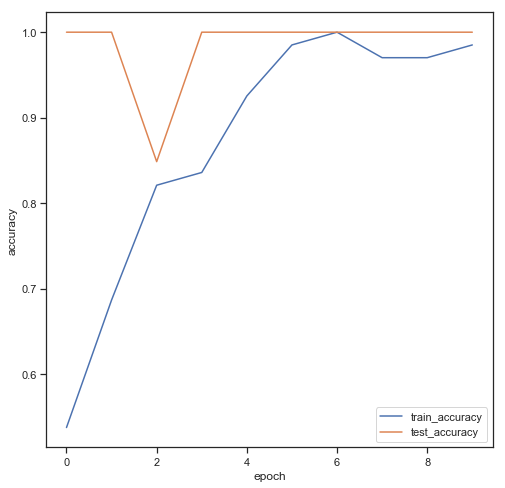

In [8]:
model_evaluation(model, x_test, y_test, verbose=False)